## GOAL

Dataset is having data of 54 sensors taken at 7 intervals.Goal of this notebook is to predict y1 which is performance metric of the batches. We have to do the predictions of y1 with shuffling the dataset and also without shuffling while doing train test split.

In [1]:
#import libraries required for wrangling,preprocessing and modelling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv',index_col=0);

This is sensor data for 54 sensors taken at different time intervals. Usually performance of system is best described by either max or minimum readings from sensors. While solving this problem we tried with different discriptive stats like 'min', 'max','std' of the sensor values and found minimum works the best.Below cell creats new data frame `der_df` which contains 'min' of recorded values of all sensors.
<br>
<br>
As given in the metadata by domain experts sensors x0 and x5 are important for prediction of y1, while solving the problem we observed that we got better results when we included all the sensors than only x0 and x5.

In [3]:
der_df = pd.DataFrame()
for i in range(0,54):
    temp = pd.concat([df['x'+str(i)+'_t0'],df['x'+str(i)+'_t1'],df['x'+str(i)+'_t2'],
                      df['x'+str(i)+'_t3'],df['x'+str(i)+'_t4'],
                      df['x'+str(i)+'_t5'],df['x'+str(i)+'_t6']],axis=1)
    temp = temp.T.describe()
    der_df['x'+str(i)+'min'] = temp.loc['min']

We did standard normalization before as best practise since some algorith which uses eucliden distances like k means, knn requires standardization.

In [4]:
sc = StandardScaler()
std_der = pd.DataFrame(sc.fit_transform(der_df),columns=der_df.columns)

In [15]:
std_der.describe()

,x0min,x1min,x2min,x3min,x4min,x5min,x6min,x7min,x8min,x9min,...,x42min,x43min,x45min,x47min,x48min,x49min,x50min,x51min,x52min,x53min
count,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,...,8.830000e+02,8.830000e+02,883.0,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02,8.830000e+02
mean,8.068606e-16,-5.972321e-18,1.152972e-16,-2.426648e-16,-2.214914e-15,2.129290e-16,3.148985e-15,4.961050e-15,1.153956e-14,1.559090e-17,...,5.069557e-16,-1.180634e-15,0.0,-2.099742e-16,-5.551115e-17,-5.029323e-17,-2.795046e-16,3.365560e-16,-2.385534e-15,-6.644364e-16
std,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,...,1.000567e+00,1.000567e+00,0.0,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00,1.000567e+00
min,-1.789816e+01,-2.343543e+00,-1.325142e+01,-3.615144e+00,-1.893430e+00,-6.709089e+00,-1.260814e+00,-1.793175e+00,-6.610886e+00,-2.322466e+00,...,-3.957319e+00,-1.148189e+00,0.0,-1.194164e+00,-1.395508e+00,-1.150064e+00,-1.944351e+00,-4.845155e+00,-4.719680e+00,-4.310191e+00
25%,-3.291533e-01,-5.100069e-01,7.546364e-02,-2.719636e-01,-5.675792e-01,-3.440841e-02,-5.445531e-01,-1.340629e+00,-1.147674e-01,-6.278206e-01,...,2.526963e-01,-1.148189e+00,0.0,-1.194164e+00,-4.997051e-01,-8.625368e-01,-3.938112e-01,3.565736e-02,-1.069049e-01,-2.510550e-01
50%,2.488954e-01,-2.019732e-01,7.546364e-02,2.516164e-02,9.534609e-02,3.464123e-01,1.909085e-02,4.648669e-01,-1.147674e-01,1.808485e-01,...,2.526963e-01,8.397536e-01,0.0,8.219864e-01,-4.606955e-01,-3.939965e-01,5.869846e-01,2.203390e-01,4.503960e-01,3.878022e-01
75%,4.787609e-01,1.029931e+00,7.546364e-02,8.634751e-01,7.582746e-01,4.525681e-01,1.909085e-02,4.648669e-01,-1.147662e-01,8.156501e-01,...,2.526963e-01,8.397536e-01,0.0,8.219864e-01,-2.914912e-01,9.482343e-01,6.888880e-01,3.867201e-01,4.503960e-01,6.156194e-01
max,1.628154e+00,1.938828e+00,7.546364e-02,1.238146e+00,2.084125e+00,1.065673e+00,3.003697e+00,1.593108e+00,3.782902e+00,2.225223e+00,...,2.526963e-01,2.827696e+00,0.0,2.838136e+00,2.449014e+00,1.699735e+00,9.495898e-01,4.879642e-01,1.223029e+00,3.266611e+00


Remove any collinear features having correlation coefficient greater than 0.9 if there are any.

In [5]:
# Create correlation matrix
corr_matrix = std_der.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

['x44min', 'x46min']

In [6]:
#dropping any collinear columns if found
std_der.drop(columns = to_drop, axis=1,inplace=True);
data = std_der.copy()

We observed when we removed outliers from x0 and x5, predictions were better. Below two cells removes outliers from x0 and x5.

In [7]:
#get quartiles
first_quartile = data['x0min'].describe()['25%']
third_quartile = data['x0min'].describe()['75%']

#interquartile range
iqr = third_quartile - first_quartile

#remove outliers
data = data[(data['x0min'] > (first_quartile - 3 * iqr)) &
            (data['x0min'] < (third_quartile + 3 * iqr))]

In [8]:
first_quartile = data['x5min'].describe()['25%']
third_quartile = data['x5min'].describe()['75%']

#interquartile range
iqr = third_quartile - first_quartile

#remove outliers
data = data[(data['x5min'] > (first_quartile - 3 * iqr)) &
            (data['x5min'] < (third_quartile + 3 * iqr))]

In [16]:
#indexing 'y1' as per 'data' since we have removed outliers
y = df['y1']
y = y[data.index]

### Prediction of y1 with shuffled train test split
After hyper parameter tuning we found Random forest works best, below cell implements the random forest with shuffled train test split.  

In [10]:
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.05,random_state=29,shuffle=True)
mod = RandomForestRegressor(max_depth=20,n_estimators=300,random_state=9)
mod.fit(X_train,y_train)
yp = mod.predict(X_test)
print('R2 Score is: ',metrics.r2_score(y_test,yp))
print('RMSE is :',metrics.mean_squared_error(y_test,yp)**0.5)

R2 Score is:  0.793900508385075
RMSE is : 0.012484088229682439


R2 Score for y1 prediction with shuffle is 0.79<br>
RMSE for y1 prediction with shuffle is 0.012

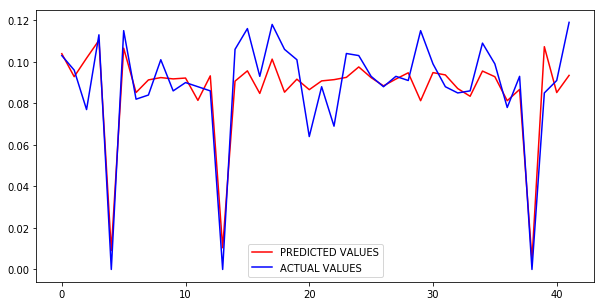

In [11]:
y_test = y_test.reset_index(drop=True)
yp = pd.Series(yp)
plt.figure(figsize=(10,5))
plt.plot(yp,'r',label='PREDICTED VALUES')
plt.plot(y_test,'b',label='ACTUAL VALUES')
plt.legend()
plt.show()

### Prediction of y1 with non shuffled train test split and using work forward validation

We tried many approaches like using average of multiple algorithms, training another algorithms on predictions of previous algorithm etc. to get better predictions but nothing worked. May be more feature engineering is required for this case.

In [13]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(data,y,test_size=0.05,random_state=42,shuffle=False)
y_test_hat = []

for idx in X_test1.index.values:
    # You may use any model of your choice here.
    rf = RandomForestRegressor(n_estimators = 300, max_depth = 17,random_state=9)
    rf.fit(X_train1, y_train1)
    y_test_hat.extend(rf.predict(X_test1.loc[X_test1.index == idx]))
    X_train1.loc[idx] = X_test1.loc[idx]
    y_train1.loc[idx] = y_test1.loc[idx]
    
y_test_hat = pd.Series(y_test_hat, index=y_test1.index)

print('R2 SCORE is :',metrics.r2_score(y_test1,y_test_hat))
print('RMSE is :',metrics.mean_squared_error(y_test1,y_test_hat)**0.5)


R2 SCORE is : 0.04665748714822415
RMSE is : 0.01559307394116086


R2 Score is 0.046<br>
RMSE is 0.015

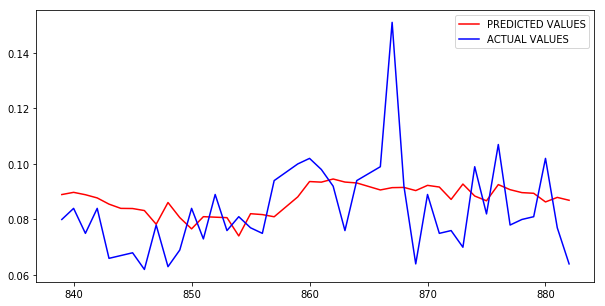

In [14]:
plt.figure(figsize=(10,5))
plt.plot(y_test_hat,'r',label='PREDICTED VALUES')
plt.plot(y_test1,'b',label='ACTUAL VALUES')
plt.legend()
plt.show()